### Sending a request to the torchserve encoder service

In [94]:
import httpx
import base64
from PIL import Image
from PIL.ImageOps import equalize, autocontrast
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import json
encode_url="http://127.0.0.1:7080/predictions/sam_vit_h_encode" # make sure to select correct port. 70* for cpu, 80* for gpu after starting both serving containers locally
#encode_url="http://127.0.0.1:8080/predictions/sam_vit_h_encode" 
#encode_url = "https://sas-gpu.ds.io/predictions/sam_vit_h_encode"
pth_fox = "../data/sample-img-fox.jpg"
input_point_fox = (150, 75)

pth_slick = "../data/tile_with_slick_512_512.png"
input_point_not_on_slick = (10, 120)
input_point_on_slick = (6, 120)
input_label = 1

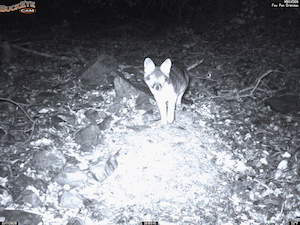

In [95]:
img_fox = Image.open(pth_fox)
img_fox

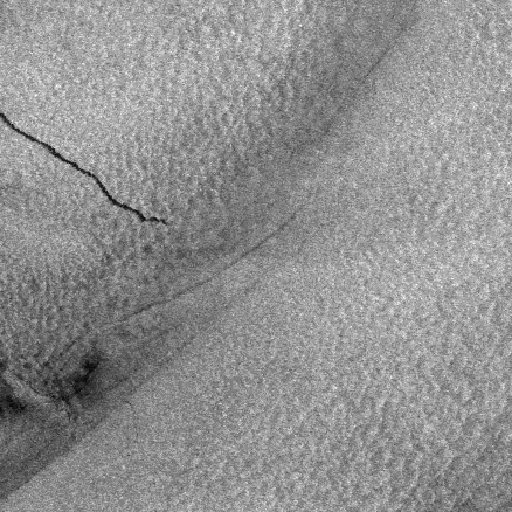

In [96]:
img_slick = Image.open(pth_slick)
autocontrast(img_slick, cutoff=0, ignore=None, mask=None, preserve_tone=False)

In [97]:
# reads image as bytes, converts bytes to string so it can be sent as a post request
with open(pth_slick, 'rb') as f:
    byte_string = f.read()
    base64_string = base64.b64encode(byte_string).decode('utf-8')

payload = {"encoded_image": base64_string}

### Time to encode image on 1080 Ti GPU

In [98]:
%%time
try:
    response = httpx.post(encode_url, json=payload, timeout=None)
except (BrokenPipeError, httpx.RemoteProtocolError) as e:
    print("wait and try again")

CPU times: user 16.2 ms, sys: 4.04 ms, total: 20.3 ms
Wall time: 1min 11s


In [99]:
response.content

b'{\n  "status": "success",\n  "image_embedding": "NwsIvjelNL5W4y++zqsqvppaI76BuSq+5bUrvpGbIL5B+ye+koQgvlPoK763ohW+XGgQviW1N77hrhi+h4YjvqNMJ75QIiG+tt4Zvm4FHL7Ghym+rlAbvu1pCL6Xwyi+spIfvuxKC77x/w++H8YXvkja571ARgW+6iLgvQKT/73Mb/+97Gz8vcLN473g5a29svbWvdpfmb0k0+K9QjzLvRqV1b1U58i95m+0vcV2WL3NMEi9BouIveimgL21Olm9/6VUvYsFD72R2SW9ZNuCvTYK171OR/e9cSMAvgBRzr0eHvi97uDRvSitrL1Ue+W9xu7MvXx92b2kJeS98zl3vbXzN764lSy+aPkgvmA/H75MZhu+BYESvvJQFr6ffBu+djoIvnT2Br4E8/69ijLdvSdfFb6TsSu+v/gbvhSICr5IzAa+8X0FvpggCb762vW9MG/9vabg6r1oiM29NnPjvXLIsr2Ox7S9JJPjvbjU2L1eCqS9lO2qvVyFn73Ifbq9LFKkvQzNjr3/EGK9HI6AvXyFNL0Hmku9Q2hzvYFFSL3w8ZO9V/BlvSnXNb2zTBS9AviMvDAHWrxwO5G7yMSouwNKsjxQLe479Oq6vDiHjb2gPia+a/0ovpklF74ewhy+ROkHvhJKzb2KMZq9bPjHvYATtL1aSqe9QGW2vWpJvb38bFi+7fdJvg1xQb5/xzu+1wE9vre+KL7cJiS+wtwpvoP6IL6eRiW+atQgvkGBGL4gURe+9XFPvtUNPL6pTSi+4nAjvkbiG75MLxm+ZV4Ovh/QEL5JrRK+rqTsvZRo+r32uuS9fPwBvl1UEb4nCwO+FqPzvXCt3r02d+29cKPuveJOxb0+aLq9dEKHvQanib1x8mq9kh3BvR0ker33m2G9/KmUvaYwhL0kBqW9gmU+vdWZCb2OMi29vgmNvLQDTjwYC128KNkVO

In [100]:
response

<Response [200 ]>

### Image embeddings for the image above

In [86]:
encoded_embedding_string = response.json()['image_embedding']
base64_bytes = base64.b64decode(encoded_embedding_string)
image_embedding = np.frombuffer(base64_bytes, dtype=np.float32)
image_embedding

array([-0.13286641, -0.17649937, -0.17171675, ..., -0.1328539 ,
       -0.1372815 , -0.1409665 ], dtype=float32)

### Sending the image embeddings to the decoder service

In [102]:
img_shape = np.array(img_slick).shape
decode_payload = {
    "image_embeddings": encoded_embedding_string,
    "image_shape": img_shape,
    "input_label": input_label,
    "input_point": input_point_on_slick
}

In [103]:
%%time
decode_url="http://127.0.0.1:7080/predictions/sam_vit_h_decode" # make sure to select correct port. 70* for cpu, 80* for gpu
#decode_url="https://sas.ds.io/predictions/sam_vit_h_decode"
response = httpx.post(decode_url, json=decode_payload, timeout=None)

CPU times: user 32.4 ms, sys: 4.05 ms, total: 36.5 ms
Wall time: 165 ms


In [104]:
response

<Response [200 ]>

In [105]:
encoded_masks_string = response.json()['masks']
base64_bytes_masks = base64.b64decode(encoded_masks_string)
masks = np.frombuffer(base64_bytes_masks, dtype=np.float32)

#### We reshape the masks to the original image shape, adding a channel for the alpha channel, so it is 4 instead of 3

In [106]:
masks = masks.reshape((1, 4, 512, 512))
masks = masks > .5

### With our encoder and decoder service, we get a solid mask prediction by just supplying a point on the object of interest!

In [107]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

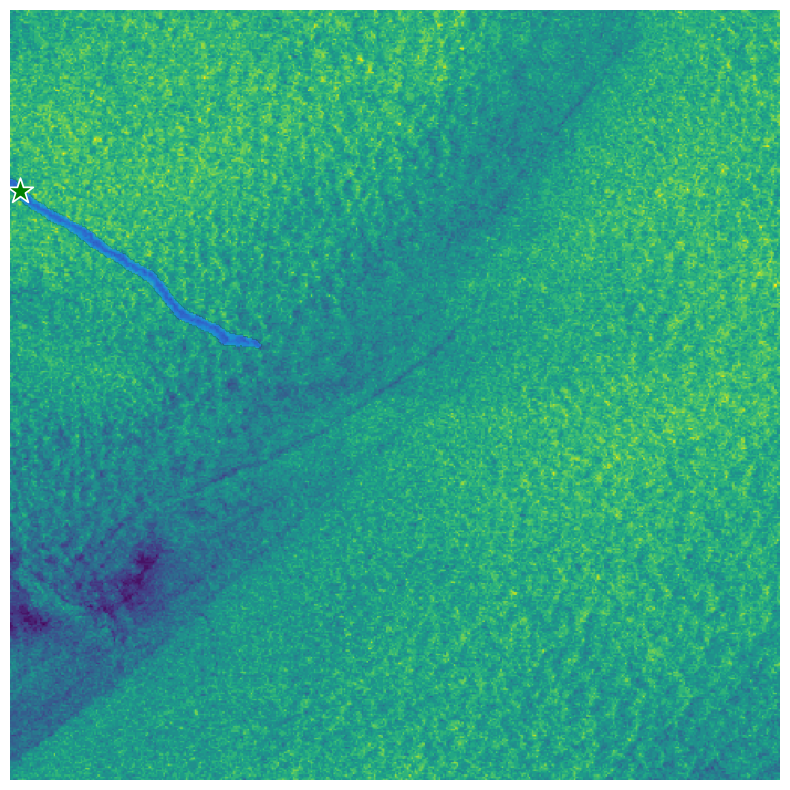

In [108]:
plt.figure(figsize=(10,10))
plt.imshow(np.array(img_slick))
show_mask(masks[:,0,:,:], plt.gca())
input_point_arr = np.array(input_point_on_slick)[np.newaxis,:]
input_label_arr = np.array(input_label)[np.newaxis]
show_points(input_point_arr, input_label_arr, plt.gca())
plt.axis('off')
plt.show() 